In [246]:
from tqdm import tqdm
from time import time
from tqdm import trange

import matplotlib.pyplot as plt
import numpy as np
import scipy

import jax
import jax.flatten_util as flatten_util
import jax.numpy as jnp

from flax import linen as nn

from typing import NamedTuple

In [247]:
seed = 56

In [248]:
class SpringState(NamedTuple):
    phi: jnp.ndarray
    buffer: jnp.ndarray
    buffer_index: jnp.ndarray
    r_hat: float
    beta: float
    checkpoint_idx: int

In [249]:
class SpringCleanState(NamedTuple):
    phi: jnp.ndarray

In [250]:
class ResNet(nn.Module):
    """A simple ResNet model."""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=50)(jnp.sin(2 * jnp.pi * x))
        x = nn.tanh(x)

        y = nn.Dense(features=50)(x)
        x = x + nn.tanh(y)

        y = nn.Dense(features=50)(x)
        x = x + nn.tanh(y)

        y = nn.Dense(features=50)(x)
        x = x + nn.tanh(y)

        x = nn.Dense(features=1)(x)
        return x


model_fn = ResNet()

In [251]:
def scalar_model_fn(params, batch):
    return model_fn.apply(params, batch)[0]


model_grad = jax.value_and_grad(scalar_model_fn, argnums=0)


def raveled_grad_fn(params, batch):
    value, grad = model_grad(params, batch)
    return value, flatten_util.ravel_pytree(grad)[0]


jacobian_fn = jax.jit(jax.vmap(raveled_grad_fn, in_axes=(None, 0), out_axes=(0, 0)))

In [252]:
key = jax.random.PRNGKey(seed)
ord = 15 #Change to make more ill conditioned

coeff = jax.random.normal(key, shape=(ord,))
poly = np.polynomial.chebyshev.Chebyshev(coeff)

def target_fn(x):
    return poly(jnp.sin(2 * jnp.pi * x)) / np.sqrt(ord)

Text(0, 0.5, 'f(s)')

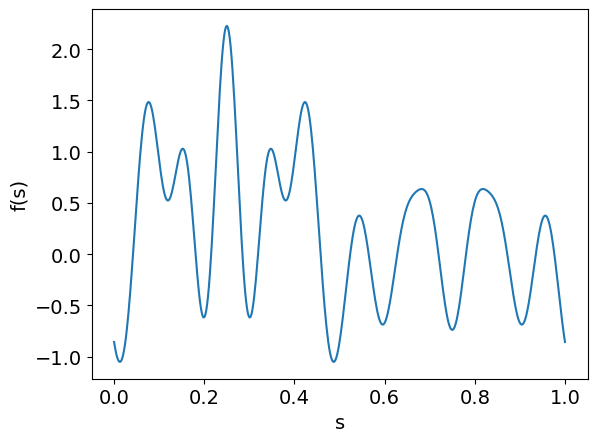

In [253]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

xs = np.linspace(0,1,500)
plt.plot(xs, target_fn(xs))
plt.xlabel("s")
plt.ylabel("f(s)")
#plt.savefig("NN_target_fn.pdf", bbox_inches='tight')

In [254]:
def loss_fn(model_params, xs):
    """Mean-squared error loss"""
    predictions = model_fn.apply(model_params, xs)
    targets = target_fn(xs)

    return jnp.mean((predictions - targets) ** 2)


loss_fn = jax.jit(loss_fn)
loss_fn_grad = jax.jit(jax.value_and_grad(loss_fn, argnums=0))

In [255]:
rng = jax.random.PRNGKey(seed)

rng, key = jax.random.split(rng)
dummy_x = jax.random.uniform(key, shape=(100, 1))

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)
param_vec, unravel_fn = flatten_util.ravel_pytree(params)

initial_params = params

print(f"nparams: {jax.flatten_util.ravel_pytree(params)[0].shape[0]}")

nparams: 7801


## NGD

In [256]:
def get_NGD_optimizer(params, rng, dummy_x, alpha, lamb):
    param_vec, unravel_fn = flatten_util.ravel_pytree(params)
    opt_state = []

    def step(params, batch, targets, opt_state, rng):
        batch_size = batch.shape[0]

        predictions, jacobian = jacobian_fn(params, batch)
        residuals = (targets - predictions)

        loss = jnp.sum(residuals**2) / batch_size

        jacobian /= jnp.sqrt(batch_size)
        residuals /= jnp.sqrt(batch_size)

        T = jacobian @ jacobian.T + lamb * jnp.eye(batch_size)

        ravel_update = jacobian.T @ jax.scipy.linalg.solve(T, residuals, assume_a="pos")

        update = unravel_fn(ravel_update)
        params = jax.tree.map(lambda p, u: p + alpha * u, params, update)

        return params, [], rng, loss, None

    return opt_state, jax.jit(step), rng

## SPRING (Clean)

In [257]:
def get_spring_optimizer_clean(params, rng, dummy_x, eta, beta, lamb):    
    param_vec, unravel_fn = flatten_util.ravel_pytree(params)
    phi = jnp.zeros_like(param_vec)
    opt_state = SpringCleanState(phi)
    
    def step(params, batch, targets, opt_state, rng):
        phi = opt_state.phi
    
        batch_size = batch.shape[0]
        predictions, jacobian = jacobian_fn(params, batch)
        residual = targets - predictions

        loss = jnp.sum(residual ** 2) / batch_size

        correction = residual - jacobian @ (beta * phi)

        jacobian /= jnp.sqrt(batch_size)
        correction /= jnp.sqrt(batch_size)

        T = jacobian @ jacobian.T + lamb * jnp.eye(batch_size)
        delta_phi = jacobian.T @ jax.scipy.linalg.solve(T, correction, assume_a="pos")
        
        phi = beta * phi + delta_phi

        update = unravel_fn(phi)        
        params = jax.tree.map(lambda p, u: p + eta * u, params, update)

        opt_state = SpringCleanState(phi)
        
        return params, opt_state, rng, loss, None
        
    return opt_state, jax.jit(step), rng

In [258]:
rng = jax.random.PRNGKey(seed)

lamb = 1e-2 #regularization parameter, same as in Kaczmarz
eta = 0.1 #learning rate 
beta = 0

num_it = 5000

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)

loss_list = []

opt_state, opt_step, rng  = get_spring_optimizer_clean(params, rng, dummy_x, eta, beta, lamb)

batch_size = 20

start_it = 20
mid_thresh = 1e-2
mid_it = None
end_it = 2500

start_params = None
mid_params = None
end_params = None

# Training loop
with trange(num_it, unit="its", position=0, leave=True) as pbar:
    for i in pbar:
        rng, key = jax.random.split(rng)
        batch = jax.random.uniform(key, shape=(batch_size, 1))
        targets = target_fn(batch)[:, 0]

        params, opt_state, rng, loss, aux = opt_step(params, batch, targets, opt_state, rng)

        if i == start_it:
          start_params = params
        if i == end_it:
          end_params = params
        if mid_it is None and loss < mid_thresh:
          mid_it = i
          mid_params = params

        if aux is not None:
            pbar.set_description(f"Loss {loss:.3e}, Aux: {aux:.3e}")
        else:
            pbar.set_description(f"Loss {loss:.3e}")

        loss_list.append(loss)

loss_list_spring = loss_list

Loss 1.549e-03: 100%|███| 5000/5000 [00:09<00:00, 518.50its/s]


Text(0, 0.5, 'Loss estimate')

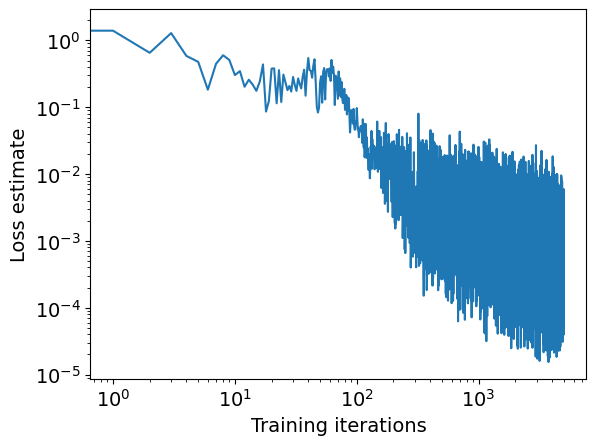

In [259]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

plt.plot(loss_list_spring)
#plt.axvline(start_it, color='black', linestyle='--')
#plt.axvline(mid_it, color='black', linestyle='--')
#plt.axvline(end_it, color='black', linestyle='--')

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")

#plt.savefig(f"NN_training.pdf", bbox_inches='tight')

## SPRING Adaptive

In [260]:
def get_spring_optimizer(params, rng, dummy_x, eta, lamb, p):
    param_vec, unravel_fn = flatten_util.ravel_pytree(params)
    phi = jnp.zeros_like(param_vec)
    buffer = jnp.zeros(2 * p)
    buffer_index = jnp.array(0)
    r_hat = 1.0
    beta = 0.9 #!!!!!
    checkpoint_idx = 1
    
    opt_state = SpringState(phi, buffer, buffer_index, r_hat, beta, checkpoint_idx)
    
    def step(params, batch, targets, opt_state, rng, step_idx):
        phi, buffer, buffer_index, r_hat, beta, checkpoint_idx = opt_state

        batch_size = batch.shape[0]
        
        predictions, jacobian = jacobian_fn(params, batch)
        residual = targets - predictions

        # Save normalized residual for adaptive momentum
        res_norm = jnp.linalg.norm(residual) / jnp.linalg.norm(targets)
        buffer = buffer.at[buffer_index % (2 * p)].set(res_norm)
        buffer_index += 1        
        
        loss = jnp.sum(residual ** 2) / batch_size

        # Correction term: r - J @ (beta * phi)
        correction = residual - jacobian @ (beta * phi) # Residual and jacobian, and phi are all not normalized
        
        jacobian /= jnp.sqrt(batch_size)
        correction /= jnp.sqrt(batch_size)
        

        # Least-squares solve: minimize || J φ - correction ||^2
        # Solution: phi = beta * phi + J.T @ ( (J J.T)^-1 @ correction )
        T = jacobian @ jacobian.T + lamb * jnp.eye(batch_size) 
        delta_phi = jacobian.T @ jax.scipy.linalg.solve(T, correction, assume_a="pos") 
        phi = beta * phi + delta_phi

        # Parameter update
        update = unravel_fn(phi)
        params = jax.tree.map(lambda p, u: p + eta * u, params, update)
        
        #update beta
        def update_beta(step_idx, beta, r_hat, checkpoint_idx):
            def update_beta_fn(args):
                buffer, beta, r_hat, checkpoint_idx, buffer_index = args
                idxs_t = (buffer_index - jnp.arange(1, p + 1)) % (2 * p)
                idxs_tp = (buffer_index - jnp.arange(p + 1, 2 * p + 1)) % (2 * p)
                eps_t = jnp.sum(buffer[idxs_t] ** 2)
                eps_tp = jnp.sum(buffer[idxs_tp] ** 2)
                r_ip = eps_t / eps_tp
    
                a_new = (checkpoint_idx + 1) ** jnp.log(checkpoint_idx + 1)
                a_old = checkpoint_idx ** jnp.log(checkpoint_idx)
                alph = a_old / a_new
    
                r_hat_new = alph * r_hat + (1 - alph) * jnp.minimum(1.0, r_ip)
                rho = jnp.maximum(0.0, 1 - r_hat_new ** (1 / p))
                beta_new = (1 - rho) / (1 + rho)
                return beta_new, r_hat_new, checkpoint_idx + 1, rho

            def skip_update(args):
                _, beta, r_hat, checkpoint_idx, _ = args
                return beta, r_hat, checkpoint_idx, jnp.nan
    
            cond = jnp.logical_and(step_idx % p == 0, step_idx >= 2 * p)
            beta, r_hat, checkpoint_idx, rho = jax.lax.cond(cond, update_beta_fn, skip_update, operand=(buffer, beta, r_hat, checkpoint_idx, buffer_index))
            return beta, r_hat, checkpoint_idx, cond
        
        beta, r_hat, checkpoint_idx, cond = update_beta(step_idx, beta, r_hat, checkpoint_idx)
        opt_state = SpringState(phi, buffer, buffer_index, r_hat, beta, checkpoint_idx)
        return params, opt_state, rng, loss, None
            
    return opt_state, jax.jit(step), rng

In [261]:
rng = jax.random.PRNGKey(seed)
lamb = 1e-2
eta = 0.1
p = 10
num_it = 5000  # Full run

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)
loss_list = []
beta_history = []
rho_history = []
update_iterations = []

opt_state, opt_step, rng = get_spring_optimizer(params, rng, dummy_x, eta, lamb, p)
batch_size = 20

print("Running full training with β tracking...")

with trange(num_it, unit="its", position=0, leave=True) as pbar:
    for i in pbar:
        rng, key = jax.random.split(rng)
        batch = jax.random.uniform(key, shape=(batch_size, 1))
        targets = target_fn(batch)[:, 0]
        params, opt_state, rng, loss, aux = opt_step(params, batch, targets, opt_state, rng, i)
        
        current_beta = float(opt_state.beta)
        beta_history.append(current_beta)
        loss_list.append(loss)
        
        # Track when β actually changes
        if i > 0 and abs(current_beta - beta_history[-2]) > 1e-6:
            update_iterations.append(i)
        
        # Show β in progress bar
        if i >= 20 and i % 10 == 0:
            pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")
        else:
            pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")
loss_list_adaptive = loss_list
beta_history_adaptive = beta_history

Running full training with β tracking...


Loss 1.170e-06, β: 0.965: 100%|█| 5000/5000 [00:09<00:00, 517.


Text(0, 0.5, 'Loss estimate')

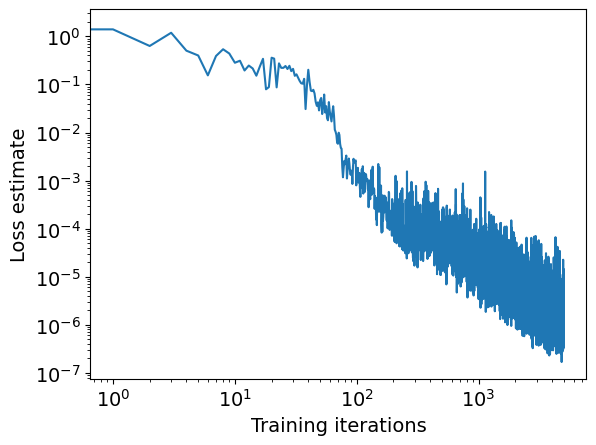

In [262]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

plt.plot(loss_list_adaptive)
#plt.axvline(start_it, color='black', linestyle='--')
#plt.axvline(mid_it, color='black', linestyle='--')
#plt.axvline(end_it, color='black', linestyle='--')

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")

#plt.savefig(f"NN_training.pdf", bbox_inches='tight')

## SPRING Adaptive New Attempt

In [263]:
def get_spring_optimizer_new(
    params,
    rng,
    dummy_x,
    eta,
    lamb,
    p,
    probe_interval=100,     # "outer loop" frequency
    probe_steps= 60,      # "inner loop" steps; default = 2p
    probe_batch_size=20  # subset of the 500 sampled to train SPRING, used to form jacobian. Use None if you want to use the same batch as SPRING
):
    param_vec, unravel_fn = flatten_util.ravel_pytree(params)
    n_params = param_vec.shape[0]


    phi = jnp.zeros_like(param_vec)
    buffer = jnp.zeros((probe_steps,), dtype=param_vec.dtype)
    buffer_index = jnp.array(0, dtype=jnp.int32)
    r_hat = jnp.array(1.0, dtype=jnp.float32)
    beta = jnp.array(0.9, dtype=jnp.float32)
    checkpoint_idx = jnp.array(1, dtype=jnp.int32)

    opt_state = SpringState(phi, buffer, buffer_index, r_hat, beta, checkpoint_idx)

    def _update_beta_from_buffer(buffer, beta, r_hat, checkpoint_idx):
        half = buffer.shape[0] // 2
        eps_tp = jnp.sum(buffer[:half] ** 2)
        eps_t  = jnp.sum(buffer[half:] ** 2)
        
        r_ip = eps_t / (eps_tp)

        a_new = (checkpoint_idx + 1) ** jnp.log(checkpoint_idx + 1.0)
        a_old = checkpoint_idx ** jnp.log(checkpoint_idx)
        alph = a_old / a_new

        r_hat_new = alph * r_hat + (1.0 - alph) * jnp.minimum(1.0, r_ip)
        rho = jnp.maximum(0.0, 1.0 - r_hat_new ** (1.0 / p))
        beta_new = (1.0 - rho) / (1.0 + rho)

        return beta_new, r_hat_new, checkpoint_idx + 1, rho

    def kaczmarz(params, rng_key, batch, p):
        """
        Runs Kaczmarz iterations on min_y ||J y - J x||^2
        with x ~ N(0,I), y0=0, and records normalized residuals into buffer.

        Returns: buffer (length 2p), rng_key_new
        """
        # Choose batch size for probe
        B = batch.shape[0]

        if probe_batch_size is None:
            m = B
        else:
            m = min(int(probe_batch_size), int(B))
        
        x_key, loop_key, key_idx = jax.random.split(rng_key, 3)
        x = jax.random.normal(x_key, (n_params,), dtype=param_vec.dtype)
        y = jnp.zeros_like(x)
        buf = jnp.zeros((probe_steps,), dtype=param_vec.dtype)


        idxs = jax.random.choice(key_idx, B, shape=(m,), replace=False)
        s = batch[idxs]                      # (m, ...) real data
        _, J = jacobian_fn(params, s)        # J: (m, n_params) fixed
        r = J @ x                            # (m,) fixed

        # Precompute row sampling distribution once (since J fixed)
        row_norm2 = jnp.sum(J * J, axis=1)
        probs = row_norm2 / jnp.sum(row_norm2)
        
        def body(i, carry):
            y, buf, key = carry
            key, key_s, key_row = jax.random.split(key, 3)

            idx = jax.random.choice(key_row, m, p=probs)

            a = J[idx]      # (n_params,)
            b = r[idx]      # scalar

            denom = jnp.dot(a, a)
            alpha = (b - jnp.dot(a, y)) / denom
            y = y + alpha * a

            # Measure normalized residual for THIS probe batch
            res = (J @ y) - r
            res_norm = jnp.linalg.norm(res) / (jnp.linalg.norm(r))

            # Write into ring-free buffer (sequential fill)
            buf = buf.at[i].set(res_norm)
            return (y, buf, key)

        y, buf, loop_key = jax.lax.fori_loop(0, probe_steps, body, (y, buf, loop_key))
        return buf, loop_key

    def step(params, batch, targets, opt_state, rng, step_idx):
        phi, buffer, buffer_index, r_hat, beta, checkpoint_idx = opt_state

        batch_size = batch.shape[0]

        predictions, jacobian = jacobian_fn(params, batch)
        residual = targets - predictions

        loss = jnp.sum(residual ** 2) / batch_size

        correction = residual - jacobian @ (beta * phi)

        jacobian = jacobian / jnp.sqrt(batch_size)
        correction = correction / jnp.sqrt(batch_size)

        T = jacobian @ jacobian.T + lamb * jnp.eye(batch_size, dtype=jacobian.dtype)
        delta_phi = jacobian.T @ jax.scipy.linalg.solve(T, correction, assume_a="pos")
        phi = beta * phi + delta_phi

        update = unravel_fn(phi)
        params = jax.tree.map(lambda p_, u_: p_ + eta * u_, params, update)

        # --- Kaczmarz-based beta update (every probe_interval steps) ---
        def do_probe_and_update(args):
            params, rng, beta, r_hat, checkpoint_idx = args
            buf, rng2 = kaczmarz(params, rng, batch, p)
            beta_new, r_hat_new, ck_new, rho = _update_beta_from_buffer(
                buf, beta, r_hat, checkpoint_idx
            )
            # store probe buffer (optional, but nice for debugging/plots)
            return buf, jnp.array(2 * p, dtype=jnp.int32), beta_new, r_hat_new, ck_new, rng2, rho

        def skip_probe(args):
            params, rng, beta, r_hat, checkpoint_idx = args
            return buffer, buffer_index, beta, r_hat, checkpoint_idx, rng, jnp.nan

        cond = (step_idx % probe_interval == 0) & (step_idx >= probe_interval)
        buffer, buffer_index, beta, r_hat, checkpoint_idx, rng, rho = jax.lax.cond(
            cond,
            do_probe_and_update,
            skip_probe,
            operand=(params, rng, beta, r_hat, checkpoint_idx)
        )

        opt_state = SpringState(phi, buffer, buffer_index, r_hat, beta, checkpoint_idx)
        return params, opt_state, rng, loss, rho  # return rho if you want to log it

    return opt_state, jax.jit(step), rng


In [264]:
rng = jax.random.PRNGKey(seed)
lamb = 1e-2
eta = 0.1
p = 10
num_it = 5000  # Full run

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)
loss_list = []
beta_history = []
rho_history = []
update_iterations = []

opt_state, opt_step, rng = get_spring_optimizer_new(params, rng, dummy_x, eta, lamb, p)
batch_size = 20 #used for training SPRING

print("Running full training with β tracking...")

with trange(num_it, unit="its", position=0, leave=True) as pbar:
    for i in pbar:
        rng, key = jax.random.split(rng)
        batch = jax.random.uniform(key, shape=(batch_size, 1))
        targets = target_fn(batch)[:, 0]
        params, opt_state, rng, loss, aux = opt_step(params, batch, targets, opt_state, rng, i)
        
        current_beta = float(opt_state.beta)
        beta_history.append(current_beta)
        loss_list.append(loss)
        
        # Track when β actually changes
        if i > 0 and abs(current_beta - beta_history[-2]) > 1e-6:
            update_iterations.append(i)
        
        # Show β in progress bar
        if i >= 20 and i % 10 == 0:
            pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")
        else:
            pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")
loss_list_new = loss_list
beta_history_new = beta_history

Running full training with β tracking...


Loss 1.180e-05, β: 0.813: 100%|█| 5000/5000 [00:10<00:00, 487.


Text(0.5, 1.0, 'β Evolution in Adaptive SPRING')

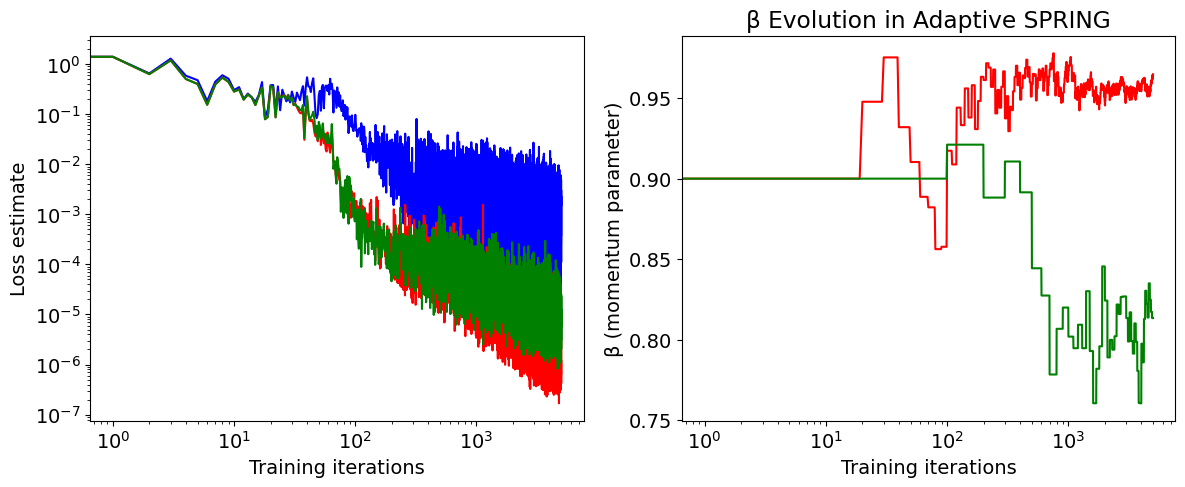

In [265]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(loss_list_spring, color="blue")
ax1.plot(loss_list_adaptive, color="red")
ax1.plot(loss_list_new, color="green")
#plt.axvline(start_it, color='black', linestyle='--')
#plt.axvline(mid_it, color='black', linestyle='--')
#plt.axvline(end_it, color='black', linestyle='--')

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel("Training iterations")
ax1.set_ylabel("Loss estimate")

ax2.plot(beta_history_adaptive, color="red")
ax2.plot(beta_history_new, color="green")
ax2.set_xscale("log")
ax2.set_xlabel("Training iterations")
ax2.set_ylabel("β (momentum parameter)")
ax2.set_title("β Evolution in Adaptive SPRING")

#plt.savefig(f"NN_training.pdf", bbox_inches='tight')

## Test across batch sizes

In [143]:
batch_sizes = [20, 50, 100, 200, 300, 400, 500]

rng = jax.random.PRNGKey(seed)
lamb = 1e-2
eta = 0.5
p = 10
num_it = 500  # Full run

losses = []

for batch in batch_sizes:
    rng, key = jax.random.split(rng)
    params = model_fn.init(key, dummy_x)
    loss_list = []
    beta_history = []
    rho_history = []
    update_iterations = []

    opt_state, opt_step, rng = get_spring_optimizer_new(params, rng, dummy_x, eta, lamb, p, probe_batch_size = batch)
    batch_size = 500 #used for training SPRING

    print(f"batch size {batch}")

    with trange(num_it, unit="its", position=0, leave=True) as pbar:
        for i in pbar:
            rng, key = jax.random.split(rng)
            batch = jax.random.uniform(key, shape=(batch_size, 1))
            targets = target_fn(batch)[:, 0]
            params, opt_state, rng, loss, aux = opt_step(params, batch, targets, opt_state, rng, i)

            current_beta = float(opt_state.beta)
            beta_history.append(current_beta)
            loss_list.append(loss)

            # Track when β actually changes
            if i > 0 and abs(current_beta - beta_history[-2]) > 1e-6:
                update_iterations.append(i)

            # Show β in progress bar
            if i >= 20 and i % 10 == 0:
                pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")
            else:
                pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")
    loss_list_new = loss_list
    beta_history_new = beta_history
    
    losses.append(loss_list_new) 

batch size 20


Loss 4.278e-08, β: 0.743: 100%|████████████████████████████████| 500/500 [00:10<00:00, 45.77its/s]


batch size 50


Loss 1.018e-07, β: 0.829: 100%|████████████████████████████████| 500/500 [00:10<00:00, 46.56its/s]


batch size 100


Loss 1.428e-07, β: 0.798: 100%|████████████████████████████████| 500/500 [00:10<00:00, 46.79its/s]


batch size 200


Loss 7.352e-07, β: 0.818: 100%|████████████████████████████████| 500/500 [00:10<00:00, 48.06its/s]


batch size 300


Loss 5.053e-08, β: 0.726: 100%|████████████████████████████████| 500/500 [00:10<00:00, 48.28its/s]


batch size 400


Loss 1.959e-08, β: 0.825: 100%|████████████████████████████████| 500/500 [00:11<00:00, 44.89its/s]


batch size 500


Loss 5.400e-07, β: 0.778: 100%|████████████████████████████████| 500/500 [00:10<00:00, 46.85its/s]


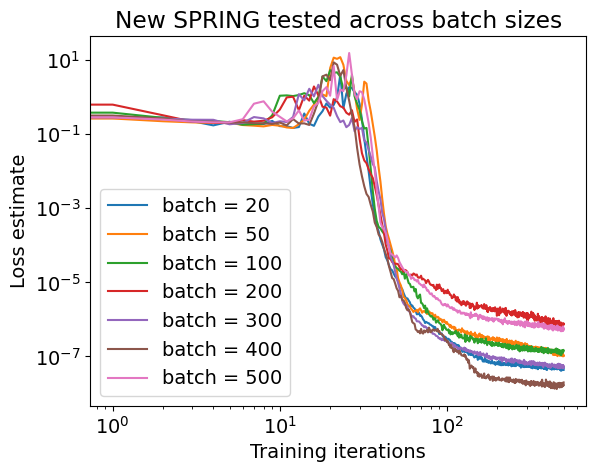

In [145]:
for i, b in enumerate(batch_sizes):
    plt.plot(losses[i], label=f"batch = {b}")

plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")
plt.title("New SPRING tested across batch sizes")
plt.legend()

## Test across inner/outer loop values

In [163]:
import itertools
probe_intervals = [10, 25, 50, 100] #outer loop
probe_steps_list = [10, 20, 40, 80]  # inner loop; keep even
cross_product = list(itertools.product(probe_intervals, probe_steps_list))

rng = jax.random.PRNGKey(seed)
lamb = 1e-2
eta = 0.5
p = 10
num_it = 500  # Full run
probe_batch_size = 400

losses = []

for pi, ps in cross_product:
    print(pi, ps)
    rng, key = jax.random.split(rng)
    params = model_fn.init(key, dummy_x)
    loss_list = []
    beta_history = []
    rho_history = []
    update_iterations = []

    opt_state, opt_step, rng = get_spring_optimizer_new(params, rng, dummy_x, eta, lamb, p, probe_batch_size=probe_batch_size, probe_interval=pi, probe_steps=ps)
    batch_size = 500 #used for training SPRING

    print(f"batch size {batch}")

    with trange(num_it, unit="its", position=0, leave=True) as pbar:
        for i in pbar:
            rng, key = jax.random.split(rng)
            batch = jax.random.uniform(key, shape=(batch_size, 1))
            targets = target_fn(batch)[:, 0]
            params, opt_state, rng, loss, aux = opt_step(params, batch, targets, opt_state, rng, i)

            current_beta = float(opt_state.beta)
            beta_history.append(current_beta)
            loss_list.append(loss)

            # Track when β actually changes
            if i > 0 and abs(current_beta - beta_history[-2]) > 1e-6:
                update_iterations.append(i)

            # Show β in progress bar
            if i >= 20 and i % 10 == 0:
                pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")
            else:
                pbar.set_description(f"Loss {loss:.3e}, β: {current_beta:.3f}")
    loss_list_new = loss_list
    beta_history_new = beta_history
    
    losses.append(loss_list_new) 

10 10
batch size [[0.2803402 ]
 [0.43872058]
 [0.42337132]
 [0.617337  ]
 [0.13176858]
 [0.8196527 ]
 [0.5559057 ]
 [0.51238275]
 [0.7659513 ]
 [0.66554594]
 [0.45692027]
 [0.2407831 ]
 [0.16124201]
 [0.76773727]
 [0.0098089 ]
 [0.5351994 ]
 [0.34968805]
 [0.10879874]
 [0.37720716]
 [0.16087568]
 [0.8176054 ]
 [0.6260582 ]
 [0.6683067 ]
 [0.09846699]
 [0.8201804 ]
 [0.45581508]
 [0.6880845 ]
 [0.79280734]
 [0.33707607]
 [0.97490895]
 [0.15065014]
 [0.41152823]
 [0.33874667]
 [0.26439404]
 [0.87765026]
 [0.9895495 ]
 [0.00666845]
 [0.28904128]
 [0.77780116]
 [0.8653306 ]
 [0.481228  ]
 [0.6960124 ]
 [0.3799311 ]
 [0.71031463]
 [0.26606703]
 [0.22827291]
 [0.13377523]
 [0.8200923 ]
 [0.61600053]
 [0.4931903 ]
 [0.98218846]
 [0.7390336 ]
 [0.34208548]
 [0.79542816]
 [0.45693493]
 [0.22692776]
 [0.9787464 ]
 [0.40002716]
 [0.45507836]
 [0.28086865]
 [0.4142965 ]
 [0.25926316]
 [0.6125635 ]
 [0.881106  ]
 [0.10427344]
 [0.01209235]
 [0.1114707 ]
 [0.98818684]
 [0.2818613 ]
 [0.6826054 ]
 [0

Loss 2.332e-08, β: 0.899: 100%|█| 500/500 [00:13<00:00, 36.72i


10 20
batch size [[3.19131494e-01]
 [7.82467484e-01]
 [8.50242734e-01]
 [9.68517661e-01]
 [2.30067134e-01]
 [5.72988391e-01]
 [7.52552152e-01]
 [4.11555171e-01]
 [8.99132490e-01]
 [5.65750241e-01]
 [2.40669847e-01]
 [6.23972058e-01]
 [8.21965218e-01]
 [5.57098508e-01]
 [5.05141258e-01]
 [9.27245975e-01]
 [6.37635946e-01]
 [4.17528152e-01]
 [9.72367525e-01]
 [1.99452281e-01]
 [7.57423878e-01]
 [9.00569081e-01]
 [3.61048102e-01]
 [2.31788158e-01]
 [4.30130243e-01]
 [9.26267266e-01]
 [4.06350374e-01]
 [6.90199971e-01]
 [6.17598176e-01]
 [6.54062629e-01]
 [9.70639825e-01]
 [8.30534220e-01]
 [1.78758740e-01]
 [7.40508080e-01]
 [7.30503440e-01]
 [6.24291420e-01]
 [8.48221779e-01]
 [6.09260082e-01]
 [8.96347523e-01]
 [7.96120167e-02]
 [9.62964892e-01]
 [5.63832164e-01]
 [7.65007496e-01]
 [8.82565022e-01]
 [2.93888330e-01]
 [2.06037641e-01]
 [3.77281070e-01]
 [6.21397495e-02]
 [8.68095517e-01]
 [7.46910095e-01]
 [4.27146673e-01]
 [2.33680964e-01]
 [7.65953064e-01]
 [7.75284410e-01]
 [5.1789319

Loss 2.429e-08, β: 0.866: 100%|█| 500/500 [00:11<00:00, 43.39i


10 40
batch size [[0.8696029 ]
 [0.07594013]
 [0.0689708 ]
 [0.7181798 ]
 [0.4251833 ]
 [0.6227132 ]
 [0.14694166]
 [0.53229237]
 [0.04240799]
 [0.2710178 ]
 [0.1631701 ]
 [0.79443574]
 [0.8462151 ]
 [0.75116587]
 [0.47296667]
 [0.16349542]
 [0.10620797]
 [0.3070737 ]
 [0.7291359 ]
 [0.5862329 ]
 [0.32349658]
 [0.73467386]
 [0.4608581 ]
 [0.50350404]
 [0.36804807]
 [0.3321041 ]
 [0.35613024]
 [0.9339869 ]
 [0.52036166]
 [0.3524927 ]
 [0.07387912]
 [0.10071349]
 [0.68628013]
 [0.76253235]
 [0.08610415]
 [0.00371909]
 [0.4621215 ]
 [0.28616238]
 [0.73843074]
 [0.17510915]
 [0.9744619 ]
 [0.47425747]
 [0.46842015]
 [0.1847583 ]
 [0.87011254]
 [0.60962665]
 [0.7598623 ]
 [0.58362687]
 [0.4510808 ]
 [0.7501035 ]
 [0.2770183 ]
 [0.54990983]
 [0.21855426]
 [0.30781043]
 [0.9921843 ]
 [0.6156961 ]
 [0.47945452]
 [0.7475493 ]
 [0.97686887]
 [0.8026773 ]
 [0.6397412 ]
 [0.6539681 ]
 [0.7388092 ]
 [0.8428087 ]
 [0.60083306]
 [0.67134356]
 [0.6464602 ]
 [0.65780854]
 [0.7358315 ]
 [0.66906357]
 [0

Loss 4.454e-07, β: 0.777: 100%|█| 500/500 [00:11<00:00, 41.74i


10 80
batch size [[0.04567277]
 [0.05862653]
 [0.20960176]
 [0.70746887]
 [0.17129219]
 [0.11417365]
 [0.92464924]
 [0.42207015]
 [0.0983938 ]
 [0.3653221 ]
 [0.99000514]
 [0.79123664]
 [0.1819148 ]
 [0.50584567]
 [0.6406411 ]
 [0.95103025]
 [0.97129154]
 [0.5187416 ]
 [0.27995026]
 [0.96294975]
 [0.8487172 ]
 [0.8594445 ]
 [0.14168549]
 [0.2274425 ]
 [0.8152878 ]
 [0.7311882 ]
 [0.5521616 ]
 [0.9384314 ]
 [0.77104604]
 [0.5427685 ]
 [0.802912  ]
 [0.20617938]
 [0.78524435]
 [0.79634166]
 [0.6889931 ]
 [0.6317818 ]
 [0.32179546]
 [0.9355608 ]
 [0.7660167 ]
 [0.90707207]
 [0.05438888]
 [0.4306003 ]
 [0.3767811 ]
 [0.7854154 ]
 [0.12139165]
 [0.9250027 ]
 [0.6900327 ]
 [0.20025802]
 [0.50932145]
 [0.36416066]
 [0.5622413 ]
 [0.6895411 ]
 [0.7022053 ]
 [0.697633  ]
 [0.7101654 ]
 [0.96802056]
 [0.83774185]
 [0.3523736 ]
 [0.65167   ]
 [0.8499243 ]
 [0.8066709 ]
 [0.3750806 ]
 [0.00697482]
 [0.7154498 ]
 [0.962324  ]
 [0.53972495]
 [0.39759052]
 [0.64939976]
 [0.45935643]
 [0.86112416]
 [0

Loss 1.864e-07, β: 0.752: 100%|█| 500/500 [00:12<00:00, 38.66i


25 10
batch size [[0.22306573]
 [0.44219267]
 [0.9363308 ]
 [0.9447818 ]
 [0.8680701 ]
 [0.8637439 ]
 [0.42706776]
 [0.09058499]
 [0.20603132]
 [0.31297243]
 [0.7806448 ]
 [0.91252685]
 [0.38344133]
 [0.22361088]
 [0.89524484]
 [0.45181572]
 [0.61736536]
 [0.9617082 ]
 [0.30431783]
 [0.79848576]
 [0.73345375]
 [0.9482399 ]
 [0.68597996]
 [0.24438322]
 [0.3542608 ]
 [0.9479923 ]
 [0.57170105]
 [0.9119216 ]
 [0.17910469]
 [0.33752656]
 [0.6992601 ]
 [0.07444525]
 [0.03332627]
 [0.09903157]
 [0.75911474]
 [0.00800502]
 [0.75090957]
 [0.69902337]
 [0.5122695 ]
 [0.5653429 ]
 [0.80085003]
 [0.3237821 ]
 [0.86431575]
 [0.64582086]
 [0.2198838 ]
 [0.47630894]
 [0.9735197 ]
 [0.49285948]
 [0.27171552]
 [0.6878743 ]
 [0.16564023]
 [0.98606765]
 [0.6884254 ]
 [0.74056566]
 [0.16167843]
 [0.8697157 ]
 [0.31108975]
 [0.9867568 ]
 [0.587919  ]
 [0.30053997]
 [0.55330074]
 [0.05565143]
 [0.65961003]
 [0.9575286 ]
 [0.4530928 ]
 [0.7634411 ]
 [0.65571046]
 [0.04430974]
 [0.7382046 ]
 [0.04535067]
 [0

Loss 4.238e-07, β: 0.915: 100%|█| 500/500 [00:12<00:00, 40.79i


25 20
batch size [[6.19592905e-01]
 [2.73905873e-01]
 [6.61931276e-01]
 [6.98249698e-01]
 [8.34150195e-01]
 [5.73654890e-01]
 [2.92056203e-01]
 [8.16330791e-01]
 [8.09856296e-01]
 [5.71143866e-01]
 [8.01133394e-01]
 [9.89090681e-01]
 [1.96959019e-01]
 [9.92542386e-01]
 [8.59946012e-01]
 [1.29196167e-01]
 [2.61180401e-01]
 [5.54314733e-01]
 [9.20920372e-02]
 [2.28857994e-02]
 [4.95532155e-01]
 [9.37150955e-01]
 [1.67864561e-01]
 [3.02782655e-01]
 [2.75051594e-02]
 [9.90453959e-01]
 [4.22190189e-01]
 [5.87447762e-01]
 [7.91754723e-01]
 [2.51618624e-01]
 [3.82071495e-01]
 [8.33075762e-01]
 [6.16214514e-01]
 [9.82664585e-01]
 [6.19010687e-01]
 [3.47543955e-01]
 [5.14299154e-01]
 [9.13306832e-01]
 [4.40785408e-01]
 [2.72131443e-01]
 [5.45502543e-01]
 [3.48819613e-01]
 [1.80743933e-02]
 [8.45040917e-01]
 [6.05279684e-01]
 [8.54313135e-01]
 [5.96419334e-01]
 [3.57175589e-01]
 [1.29394174e-01]
 [8.62400889e-01]
 [5.90289950e-01]
 [3.29687834e-01]
 [8.87585402e-01]
 [8.89532089e-01]
 [3.3672380

Loss 1.684e-07, β: 0.904: 100%|█| 500/500 [00:11<00:00, 43.21i


25 40
batch size [[4.81112123e-01]
 [8.24939013e-02]
 [7.58583188e-01]
 [3.78070235e-01]
 [9.92606878e-01]
 [6.61495090e-01]
 [6.39048457e-01]
 [2.04205275e-01]
 [2.71815777e-01]
 [9.49150324e-02]
 [5.77697039e-01]
 [1.52126074e-01]
 [2.21994281e-01]
 [9.65292931e-01]
 [7.17961431e-01]
 [6.65018559e-02]
 [6.28376722e-01]
 [4.52267408e-01]
 [4.71078396e-01]
 [6.49156451e-01]
 [5.61733484e-01]
 [9.59728479e-01]
 [1.06146932e-01]
 [4.60505366e-01]
 [7.19727159e-01]
 [7.14419365e-01]
 [3.96359563e-01]
 [2.94330478e-01]
 [8.20082784e-01]
 [3.29596877e-01]
 [7.77774811e-01]
 [6.56824470e-01]
 [8.81294608e-01]
 [2.14489460e-01]
 [7.78447628e-01]
 [2.41381645e-01]
 [5.97110152e-01]
 [4.85079288e-02]
 [9.65586543e-01]
 [7.48403311e-01]
 [4.25858617e-01]
 [3.20370793e-01]
 [4.48094368e-01]
 [5.49700737e-01]
 [9.91549373e-01]
 [5.07020354e-01]
 [3.56907129e-01]
 [9.71831083e-01]
 [7.97498345e-01]
 [1.91831350e-01]
 [3.47988486e-01]
 [6.77067041e-01]
 [5.37722111e-01]
 [1.27837777e-01]
 [6.5325057

Loss 4.200e-08, β: 0.884: 100%|█| 500/500 [00:11<00:00, 42.43i


25 80
batch size [[0.4247371 ]
 [0.30420542]
 [0.7054367 ]
 [0.87493896]
 [0.10778046]
 [0.53528523]
 [0.91413426]
 [0.1476003 ]
 [0.26536202]
 [0.8572414 ]
 [0.51005816]
 [0.22303247]
 [0.4000814 ]
 [0.08271849]
 [0.2571162 ]
 [0.9360033 ]
 [0.84919393]
 [0.523509  ]
 [0.0280503 ]
 [0.6104363 ]
 [0.27633083]
 [0.87273943]
 [0.43034017]
 [0.48637795]
 [0.48241305]
 [0.62400746]
 [0.19612956]
 [0.51627004]
 [0.14115095]
 [0.19299304]
 [0.3365581 ]
 [0.98089623]
 [0.71128345]
 [0.31522536]
 [0.12541711]
 [0.51690686]
 [0.12490904]
 [0.56170547]
 [0.4875996 ]
 [0.6665163 ]
 [0.29977632]
 [0.8439009 ]
 [0.18893695]
 [0.59629977]
 [0.31718516]
 [0.03041232]
 [0.7205162 ]
 [0.07130408]
 [0.82398534]
 [0.0126971 ]
 [0.29162896]
 [0.08262599]
 [0.6731721 ]
 [0.5709255 ]
 [0.1353693 ]
 [0.11221492]
 [0.761819  ]
 [0.43946266]
 [0.3553778 ]
 [0.3343519 ]
 [0.6733333 ]
 [0.78508353]
 [0.27922332]
 [0.14578879]
 [0.8857862 ]
 [0.06038475]
 [0.14333045]
 [0.97426295]
 [0.56972456]
 [0.10772872]
 [0

Loss 1.022e-07, β: 0.831: 100%|█| 500/500 [00:12<00:00, 41.25i


50 10
batch size [[5.51894665e-01]
 [4.63809729e-01]
 [8.34212780e-01]
 [1.56409144e-01]
 [6.41140223e-01]
 [9.46621180e-01]
 [8.84563923e-02]
 [5.22628784e-01]
 [6.43741727e-01]
 [7.20994473e-02]
 [3.28415036e-01]
 [6.87674403e-01]
 [9.25794005e-01]
 [9.82215881e-01]
 [7.75845647e-01]
 [5.65594077e-01]
 [6.72787428e-01]
 [6.34680748e-01]
 [6.29656553e-01]
 [5.15136957e-01]
 [4.07377839e-01]
 [3.67478967e-01]
 [3.22145700e-01]
 [9.00937200e-01]
 [7.79505491e-01]
 [1.65702820e-01]
 [6.70873523e-01]
 [7.06254244e-01]
 [8.07445407e-01]
 [3.44666243e-01]
 [6.22021317e-01]
 [4.15812373e-01]
 [5.97988725e-01]
 [5.31856060e-01]
 [3.60247970e-01]
 [4.65472221e-01]
 [7.16156125e-01]
 [8.78116131e-01]
 [5.60245037e-01]
 [3.67258787e-02]
 [7.62822509e-01]
 [4.92124557e-02]
 [3.93771529e-01]
 [7.09932446e-01]
 [4.01560783e-01]
 [7.72913933e-01]
 [4.70324159e-01]
 [6.59796596e-01]
 [8.67833734e-01]
 [1.56450272e-02]
 [4.98373389e-01]
 [9.01342630e-01]
 [1.39968753e-01]
 [1.94868088e-01]
 [1.4704310

Loss 2.474e-07, β: 0.886: 100%|█| 500/500 [00:10<00:00, 46.30i


50 20
batch size [[2.09486961e-01]
 [1.55782223e-01]
 [9.84552264e-01]
 [1.96613073e-02]
 [5.82088232e-02]
 [5.30372262e-01]
 [8.57734323e-01]
 [4.01418209e-01]
 [8.90383601e-01]
 [5.08268356e-01]
 [2.47646451e-01]
 [3.42980623e-01]
 [2.76812673e-01]
 [6.51744843e-01]
 [9.20008421e-02]
 [4.78703141e-01]
 [3.31760287e-01]
 [6.61628485e-01]
 [7.36926675e-01]
 [3.61421347e-01]
 [2.66451001e-01]
 [7.84422040e-01]
 [7.90155649e-01]
 [1.15435004e-01]
 [9.60492253e-01]
 [8.92947793e-01]
 [6.95632458e-01]
 [8.37891340e-01]
 [4.51743007e-01]
 [5.25059938e-01]
 [2.92988658e-01]
 [1.82763696e-01]
 [2.37664819e-01]
 [9.59111571e-01]
 [1.34655356e-01]
 [3.13783288e-01]
 [6.65820599e-01]
 [8.27658176e-01]
 [4.80093479e-01]
 [8.98967862e-01]
 [3.95740271e-02]
 [9.43719864e-01]
 [3.18539023e-01]
 [2.90401459e-01]
 [8.93332481e-01]
 [9.26503181e-01]
 [1.36506915e-01]
 [9.13400292e-01]
 [8.50003839e-01]
 [5.24295211e-01]
 [9.65104938e-01]
 [8.89840364e-01]
 [7.89201140e-01]
 [7.72747874e-01]
 [5.5760622

Loss 5.391e-08, β: 0.879: 100%|█| 500/500 [00:10<00:00, 47.65i


50 40
batch size [[0.04951108]
 [0.58208907]
 [0.769024  ]
 [0.13178146]
 [0.31556714]
 [0.94956636]
 [0.70223653]
 [0.11954856]
 [0.1140697 ]
 [0.5533923 ]
 [0.18400145]
 [0.87412417]
 [0.06480312]
 [0.78619874]
 [0.6662873 ]
 [0.39751744]
 [0.91942275]
 [0.83086944]
 [0.31366646]
 [0.7268089 ]
 [0.18294322]
 [0.9200252 ]
 [0.6507225 ]
 [0.99813604]
 [0.04048336]
 [0.8350885 ]
 [0.1367265 ]
 [0.40210748]
 [0.24426961]
 [0.61854374]
 [0.29993582]
 [0.46672916]
 [0.9960873 ]
 [0.22910607]
 [0.4868058 ]
 [0.5092374 ]
 [0.5220573 ]
 [0.08295441]
 [0.09565544]
 [0.6764653 ]
 [0.9690925 ]
 [0.80820954]
 [0.9194102 ]
 [0.22699618]
 [0.91641736]
 [0.22656131]
 [0.23413157]
 [0.4293939 ]
 [0.602535  ]
 [0.67109084]
 [0.15974355]
 [0.28818142]
 [0.12868786]
 [0.839985  ]
 [0.8970679 ]
 [0.34358287]
 [0.4934013 ]
 [0.12734938]
 [0.38740838]
 [0.376701  ]
 [0.3254106 ]
 [0.35555935]
 [0.48348355]
 [0.8537375 ]
 [0.9173522 ]
 [0.9207268 ]
 [0.78006876]
 [0.07123315]
 [0.08538413]
 [0.88062537]
 [0

Loss 6.749e-08, β: 0.815: 100%|█| 500/500 [00:10<00:00, 48.07i


50 80
batch size [[4.30139303e-01]
 [4.19572830e-01]
 [9.80915546e-01]
 [7.01273203e-01]
 [2.19672561e-01]
 [3.35012555e-01]
 [2.92940140e-01]
 [9.61502910e-01]
 [4.94310141e-01]
 [4.48030233e-02]
 [1.53221130e-01]
 [2.69681215e-02]
 [5.71256757e-01]
 [8.90913010e-01]
 [2.07421660e-01]
 [5.73435187e-01]
 [5.07426023e-01]
 [1.13972902e-01]
 [9.79562998e-01]
 [5.19711375e-01]
 [2.90964603e-01]
 [5.74358940e-01]
 [4.66894746e-01]
 [6.63751602e-01]
 [9.05053854e-01]
 [6.10550642e-01]
 [3.86593461e-01]
 [6.74673438e-01]
 [4.41159725e-01]
 [8.08903933e-01]
 [9.12705779e-01]
 [2.89804697e-01]
 [9.84189510e-01]
 [2.30630875e-01]
 [3.52966666e-01]
 [1.00747705e-01]
 [4.40909386e-01]
 [9.15778995e-01]
 [2.59552836e-01]
 [8.43316197e-01]
 [7.89708853e-01]
 [1.57911539e-01]
 [5.58776736e-01]
 [5.64057827e-01]
 [8.77270937e-01]
 [7.17738271e-01]
 [2.32161641e-01]
 [3.00528288e-01]
 [4.16187525e-01]
 [6.39646888e-01]
 [5.96720695e-01]
 [7.81801105e-01]
 [5.21874428e-01]
 [9.10734534e-01]
 [6.7673683

Loss 5.104e-08, β: 0.770: 100%|█| 500/500 [00:12<00:00, 41.39i


100 10
batch size [[1.20221853e-01]
 [4.13009167e-01]
 [3.51157546e-01]
 [6.90779686e-01]
 [3.16311836e-01]
 [1.33592129e-01]
 [9.25553679e-01]
 [4.35985208e-01]
 [6.42482996e-01]
 [2.06457138e-01]
 [5.59120417e-01]
 [9.56697702e-01]
 [2.42118239e-01]
 [4.96867061e-01]
 [8.50135207e-01]
 [7.11004138e-01]
 [2.76579857e-01]
 [3.97196293e-01]
 [1.06588602e-02]
 [1.18329167e-01]
 [1.41844630e-01]
 [1.81217194e-02]
 [7.96201468e-01]
 [2.79331207e-02]
 [9.24555182e-01]
 [5.43255091e-01]
 [6.99491262e-01]
 [3.58064413e-01]
 [9.59357738e-01]
 [9.42222834e-01]
 [4.29968834e-02]
 [1.07897043e-01]
 [3.71803045e-01]
 [6.20387316e-01]
 [1.87866211e-01]
 [7.53174663e-01]
 [9.03002024e-02]
 [7.32329130e-01]
 [7.48822808e-01]
 [3.26258302e-01]
 [4.61239457e-01]
 [8.31693172e-01]
 [1.43466830e-01]
 [7.15819955e-01]
 [1.12796545e-01]
 [6.55632854e-01]
 [8.97563100e-01]
 [1.60962939e-01]
 [3.16153049e-01]
 [3.54962587e-01]
 [9.53776240e-01]
 [4.54519272e-01]
 [9.89429593e-01]
 [9.68656301e-01]
 [4.504112

Loss 2.413e-08, β: 0.952: 100%|█| 500/500 [00:11<00:00, 43.65i


100 20
batch size [[0.22452247]
 [0.98846185]
 [0.61221874]
 [0.90025115]
 [0.85657203]
 [0.3388728 ]
 [0.89598894]
 [0.6915759 ]
 [0.47466135]
 [0.79462445]
 [0.5695194 ]
 [0.8140383 ]
 [0.56036866]
 [0.950302  ]
 [0.23365021]
 [0.23029017]
 [0.43293178]
 [0.04307222]
 [0.0816071 ]
 [0.01582634]
 [0.00409901]
 [0.3343737 ]
 [0.12587929]
 [0.7461268 ]
 [0.38729596]
 [0.89508116]
 [0.9305142 ]
 [0.44250488]
 [0.79398024]
 [0.37669158]
 [0.27487946]
 [0.27815473]
 [0.33124602]
 [0.6303408 ]
 [0.59294283]
 [0.8919456 ]
 [0.14251435]
 [0.01603758]
 [0.09447205]
 [0.01069319]
 [0.71977746]
 [0.04517293]
 [0.26317787]
 [0.46667206]
 [0.93769836]
 [0.10002816]
 [0.5604793 ]
 [0.9699112 ]
 [0.43983388]
 [0.4501084 ]
 [0.1288091 ]
 [0.8833697 ]
 [0.4636557 ]
 [0.13883626]
 [0.4587567 ]
 [0.00446427]
 [0.98047996]
 [0.35019696]
 [0.02444625]
 [0.51967406]
 [0.49468255]
 [0.93589604]
 [0.24656737]
 [0.17343068]
 [0.664657  ]
 [0.66543436]
 [0.771376  ]
 [0.8902825 ]
 [0.3235377 ]
 [0.4643922 ]
 [

Loss 7.680e-08, β: 0.858: 100%|█| 500/500 [00:11<00:00, 45.38i


100 40
batch size [[9.73364472e-01]
 [8.50066423e-01]
 [4.82105136e-01]
 [1.19580984e-01]
 [3.23458910e-01]
 [1.03557587e-01]
 [3.96206737e-01]
 [9.28938389e-03]
 [1.53460860e-01]
 [3.18028092e-01]
 [8.61459970e-02]
 [1.52797699e-02]
 [2.10239649e-01]
 [8.32396269e-01]
 [4.46743369e-01]
 [6.81420684e-01]
 [1.48061037e-01]
 [3.63663197e-01]
 [3.85603905e-02]
 [5.89041233e-01]
 [3.62782478e-02]
 [6.19053841e-01]
 [4.88680959e-01]
 [6.39171362e-01]
 [9.77109671e-01]
 [4.38784003e-01]
 [6.80104494e-01]
 [5.30610085e-01]
 [4.02734160e-01]
 [9.17727947e-01]
 [2.47724891e-01]
 [6.33278728e-01]
 [2.37303972e-02]
 [1.01204515e-01]
 [8.09110761e-01]
 [4.52980280e-01]
 [3.35838437e-01]
 [6.96118712e-01]
 [1.56844974e-01]
 [8.43445778e-01]
 [6.83988333e-01]
 [2.85637259e-01]
 [5.09136200e-01]
 [6.07033730e-01]
 [3.01925540e-01]
 [2.33571410e-01]
 [8.93032908e-01]
 [2.03231692e-01]
 [2.63749719e-01]
 [4.65768456e-01]
 [9.07485247e-01]
 [3.67044449e-01]
 [1.68205380e-01]
 [9.08291698e-01]
 [9.432036

Loss 1.682e-07, β: 0.822: 100%|█| 500/500 [00:10<00:00, 47.45i


100 80
batch size [[5.93729138e-01]
 [2.68946886e-01]
 [4.66549158e-01]
 [6.99257255e-01]
 [9.33687568e-01]
 [4.87460375e-01]
 [4.03777003e-01]
 [5.15040040e-01]
 [6.78315997e-01]
 [9.48880196e-01]
 [9.38053727e-01]
 [7.18435884e-01]
 [6.38515234e-01]
 [8.79845500e-01]
 [7.08951950e-02]
 [4.25504565e-01]
 [9.33393598e-01]
 [9.62741017e-01]
 [8.11154246e-01]
 [6.47222400e-01]
 [7.03378916e-02]
 [3.11048269e-01]
 [2.53164768e-01]
 [4.46371078e-01]
 [5.89666009e-01]
 [4.15287018e-01]
 [3.13258410e-01]
 [3.48692656e-01]
 [7.03393340e-01]
 [9.11224484e-01]
 [6.65620565e-01]
 [1.75152183e-01]
 [3.53873968e-01]
 [4.77992058e-01]
 [7.81946182e-02]
 [1.70661926e-01]
 [5.63731194e-02]
 [4.49165106e-02]
 [6.95812702e-02]
 [3.06190729e-01]
 [5.65795541e-01]
 [2.06275105e-01]
 [6.74066901e-01]
 [7.23572135e-01]
 [7.37111092e-01]
 [7.56199121e-01]
 [4.88149881e-01]
 [4.58996296e-01]
 [1.65697694e-01]
 [5.56462407e-01]
 [8.89301300e-05]
 [2.41573215e-01]
 [3.34014773e-01]
 [8.93546462e-01]
 [1.262630

Loss 1.851e-07, β: 0.836: 100%|█| 500/500 [00:10<00:00, 45.93i


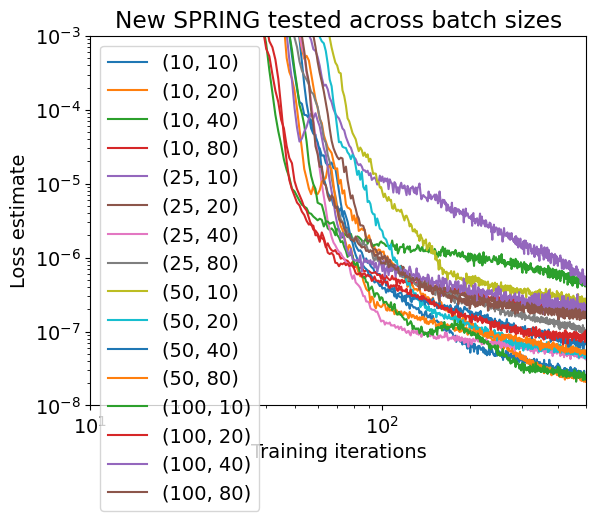

In [166]:
for i, (pi, ps) in enumerate(cross_product):
    plt.plot(losses[i], label=f"{pi, ps}")

plt.xlim(1e1, 500)    
plt.ylim(1e-8, 1e-3)

plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")
plt.title("New SPRING tested across batch sizes")
plt.legend()